In [1]:
import pandas as pd
import numpy as np
import pickle
import spacy
import time

In [9]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
save_frame = pd.read_pickle('embeddings_1_17_33_45_58_81_86.pickle')
save_frame = save_frame[(save_frame['1_step']==1)|(save_frame['1_step']==17)|(save_frame['1_step']==33)].copy()
save_frame

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259..."
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738..."
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398..."
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132..."
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246..."
...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0..."
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636..."
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260..."
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0..."


### Предсказали 1.5


In [4]:
labels = save_frame[['1_step', '1.5_steps',	'2_steps', '2.5_steps',	'3_steps',	'4_steps']]
set(list(labels['1.5_steps']))

{11, 12, 13, 14, 16, 17, 171, 172, 331, 332}

In [5]:
X_train, X_test, y_train, y_test = train_test_split(list(save_frame['embedding']), list(labels['1.5_steps']), test_size=0.2, random_state=42)
start_time = time.time()
model = LogisticRegression(multi_class='ovr', solver ='newton-cg' )
model.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 502.49965739250183 seconds ---


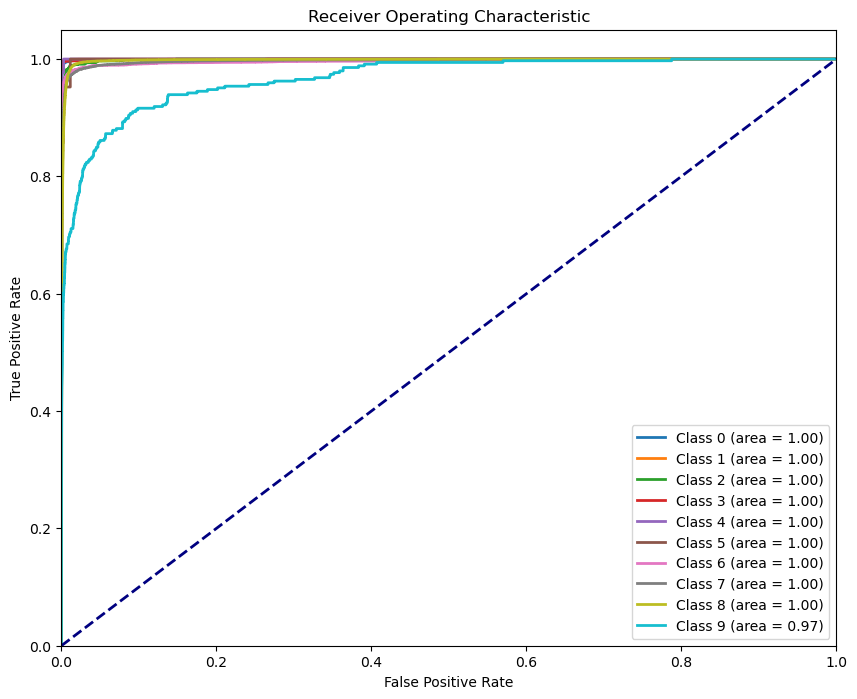

In [10]:
# Бинаризация меток для многоклассовой классификации
y_test_binarized = label_binarize(y_test, classes=np.unique(labels['1.5_steps']))

# Предсказание вероятностей для всех классов
y_score = model.predict_proba(X_test)

# Вычисление параметров ROC-кривых для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривых для всех классов
plt.figure(figsize=(10, 8))

classes_to_see = [0,1, 2, 3]
for i in range(y_test_binarized.shape[1]): # range(y_test_binarized.shape[1])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

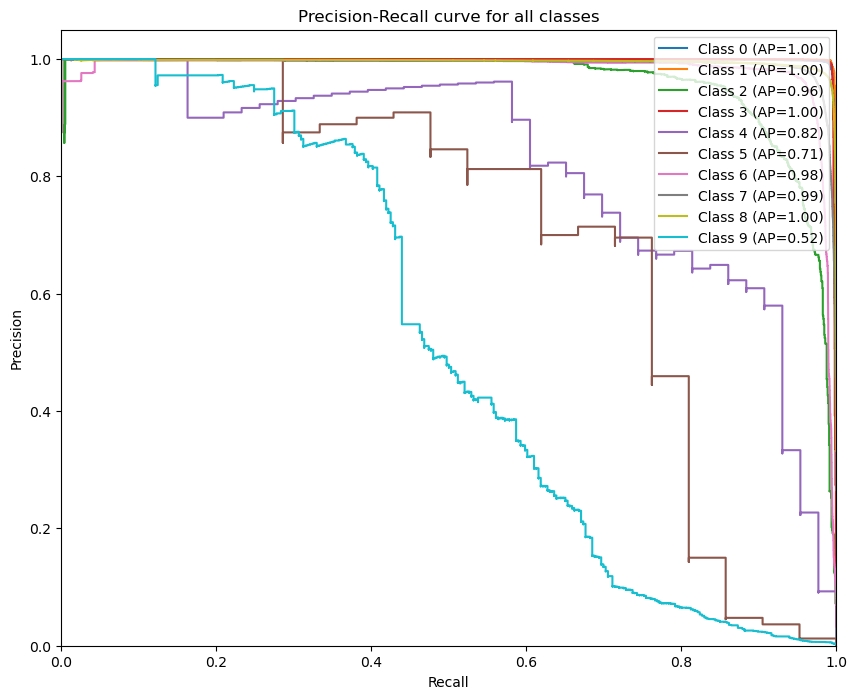

In [11]:
# Расчет кривых точности и полноты для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
for i in range(y_test_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# Построение графиков кривых точности-полноты для всех классов
plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
    plt.step(recall[i], precision[i], where='post', 
             label='Class {} (AP={:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for all classes')
plt.legend(loc="upper right")
plt.show()


In [12]:
model_classes = model.classes_
print(model_classes)

[ 11  12  13  14  16  17 171 172 331 332]


In [13]:
save_frame['predicted_1.5_steps'] = model.predict(list(save_frame['embedding']))
save_frame.head()

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14


### Последовательная классификация - с использованием знаний прошлой ступени

In [14]:
X = np.array(save_frame['embedding'].tolist())  # Convert embedding lists to a numpy array

y = save_frame['2.5_steps']

predicted_steps = save_frame['predicted_1.5_steps'].values.reshape(-1, 1)
X_combined = np.hstack((X, predicted_steps))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [15]:
start_time = time.time()
model2 = LogisticRegression(multi_class='ovr', solver='newton-cg')
model2.fit(X_train2, y_train2)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5140.203495979309 seconds ---


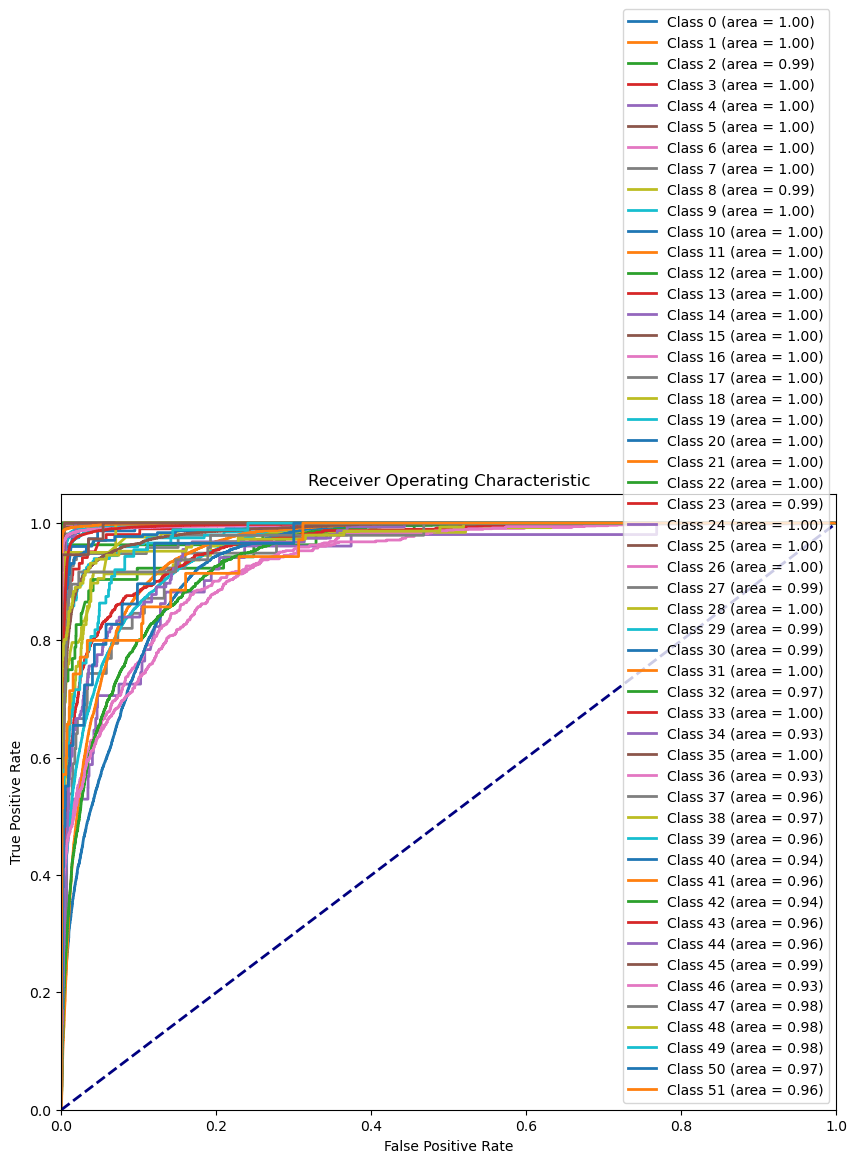

In [21]:
# Бинаризация меток для многоклассовой классификации
y_test_binarized2 = label_binarize(y_test2, classes=np.unique(y))

# Предсказание вероятностей для всех классов
y_score2 = model2.predict_proba(X_test2)

# Вычисление параметров ROC-кривых для каждого класса
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(y_test_binarized2.shape[1]):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_binarized2[:, i], y_score2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Построение ROC-кривых для всех классов
plt.figure(figsize=(10, 8))

#classes_to_see2 = [0,1, 2, 3, 4]
for i in range(y_test_binarized2.shape[1]): # classes_to_see2
    plt.plot(fpr2[i], tpr2[i], lw=2, label='Class {} (area = {:.2f})'.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



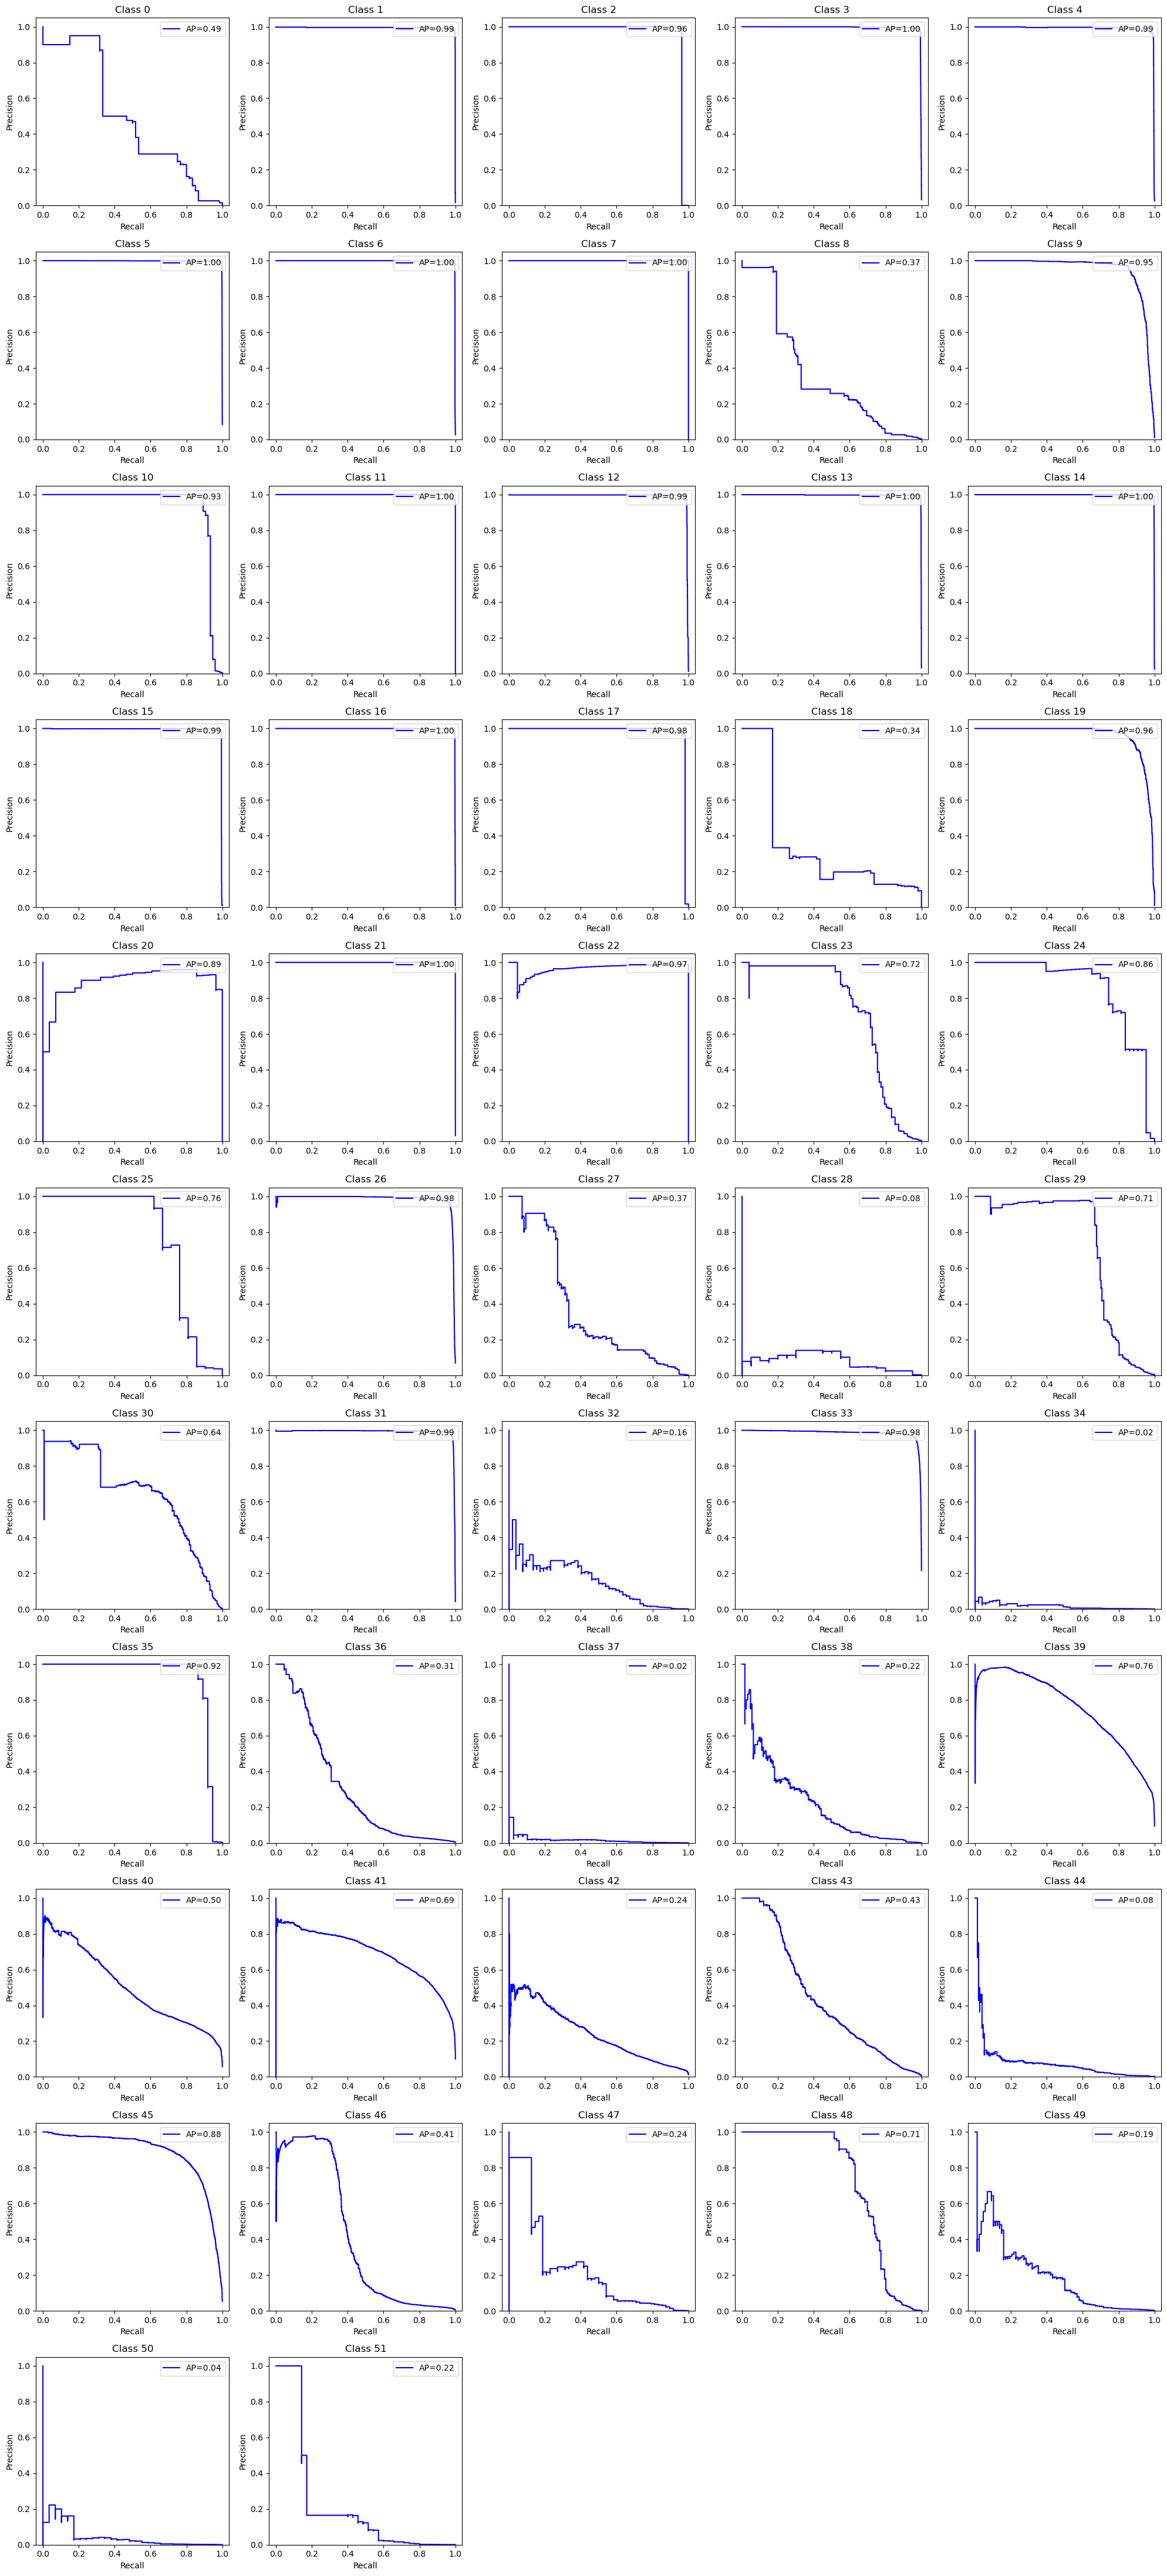

In [22]:
# Предполагается, что y_test_binarized и y_score уже вычислены
n_classes2 = y_test_binarized2.shape[1]  # количество классов

# Инициализация словарей
precision2 = dict()
recall2 = dict()
average_precision2 = dict()

# Расчет точности и полноты для каждого класса
for i in range(n_classes2):
    precision2[i], recall2[i], _ = precision_recall_curve(y_test_binarized2[:, i], y_score2[:, i])
    average_precision2[i] = average_precision_score(y_test_binarized2[:, i], y_score2[:, i])

# Выбор размера сетки подграфиков в зависимости от количества классов
rows2 = int(np.ceil(n_classes2 / 5))
cols2 = 5

# Создание фигуры для подграфиков
figsize_per_subplot2 = 4
fig2, axes2 = plt.subplots(rows2, cols2, figsize=(figsize_per_subplot2 * cols2, figsize_per_subplot2 * rows2))

for i, ax in enumerate(axes2.flatten()):
    if i < n_classes2:
        ax.step(recall2[i], precision2[i], where='post', color='b', label=f'AP={average_precision2[i]:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title(f'Class {i}')
        ax.legend(loc="upper right")
        ax.set_aspect('equal', adjustable='datalim')
    else:
        ax.set_visible(False)

for i in range(n_classes2, rows2 * cols2):
    fig2.delaxes(axes2.flatten()[i])

plt.tight_layout()
plt.show()


In [24]:
save_frame['predicted_2.5_steps'] = save_frame.apply(lambda row: model2.predict(np.hstack((np.array(row['embedding']), np.array([row['predicted_1.5_steps']]))).reshape(1, -1)), axis=1)
save_frame['predicted_2.5_steps'] = save_frame['predicted_2.5_steps'].apply(lambda x: int(x[0]))

save_frame.head()

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps,predicted_2.5_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11,1131
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12,1241
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11,1131
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11,1134
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14,1472


In [25]:
print(save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps']].shape)
save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps']].groupby('2.5_steps')['text'].count()

(104109, 11)


2.5_steps
1116       191
1117        74
1119         3
1131       274
1133       202
1134       268
1135       119
1138         1
1139       852
1192      1028
1193        40
1211         3
1221       117
1231       121
1241       154
1242        66
1251        35
1253         6
1281       186
1301      1016
1412        12
1472        53
1491        16
1492       160
1611        83
1701        54
17121     2172
17124      281
17125      121
17127      326
17211      660
17221      726
17229      251
17231     4206
17239      245
17241       22
17291     2844
17299      189
33111      521
33121    19450
33122    26988
33131    17792
33141     8135
33151     3701
33161      720
33171     5628
33191     2812
33202      238
33203      299
33204      383
33205      100
33207      165
Name: text, dtype: int64

Попытка 2, увеличиваем размерность предсказанной ступени

In [27]:
X3 = np.array(save_frame['embedding'].tolist())  # Convert embedding lists to a numpy array

y3 = save_frame['2.5_steps']

predicted_steps3 = np.tile(save_frame['predicted_1.5_steps'].values.reshape(-1, 1), (1, 2))
X_combined3 = np.hstack((X3, predicted_steps3))

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_combined3, y3, test_size=0.2, random_state=42)

In [34]:
start_time = time.time()
model3 = LogisticRegression(multi_class='ovr', solver='newton-cg')
model3.fit(X_train3, y_train3)
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Sergey\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Sergey\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Sergey\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Sergey\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Бинаризация меток для многоклассовой классификации
y_test_binarized3 = label_binarize(y_test3, classes=np.unique(y3))

# Предсказание вероятностей для всех классов
y_score3 = model3.predict_proba(X_test3)

# Вычисление параметров ROC-кривых для каждого класса
fpr3 = dict()
tpr3 = dict()
roc_auc3 = dict()
for i in range(y_test_binarized3.shape[1]):
    fpr3[i], tpr3[i], _ = roc_curve(y_test_binarized3[:, i], y_score3[:, i])
    roc_auc3[i] = auc(fpr3[i], tpr3[i])

# Построение ROC-кривых для всех классов
plt.figure(figsize=(10, 8))

#classes_to_see2 = [0,1, 2, 3, 4]
for i in range(y_test_binarized3.shape[1]): # classes_to_see2
    plt.plot(fpr3[i], tpr3[i], lw=2, label='Class {} (area = {:.2f})'.format(i, roc_auc3[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Предполагается, что y_test_binarized и y_score уже вычислены
n_classes3 = y_test_binarized3.shape[1]  # количество классов

# Инициализация словарей
precision3 = dict()
recall3 = dict()
average_precision3 = dict()

# Расчет точности и полноты для каждого класса
for i in range(n_classes3):
    precision3[i], recall3[i], _ = precision_recall_curve(y_test_binarized3[:, i], y_score3[:, i])
    average_precision3[i] = average_precision_score(y_test_binarized3[:, i], y_score3[:, i])

# Выбор размера сетки подграфиков в зависимости от количества классов
rows3 = int(np.ceil(n_classes3 / 5))
cols3 = 5

# Создание фигуры для подграфиков
figsize_per_subplot3 = 4
fig3, axes3 = plt.subplots(rows3, cols3, figsize=(figsize_per_subplot3 * cols3, figsize_per_subplot3 * rows3))

for i, ax in enumerate(axes3.flatten()):
    if i < n_classes3:
        ax.step(recall3[i], precision3[i], where='post', color='b', label=f'AP={average_precision3[i]:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title(f'Class {i}')
        ax.legend(loc="upper right")
        ax.set_aspect('equal', adjustable='datalim')
    else:
        ax.set_visible(False)

for i in range(n_classes3, rows3 * cols3):
    fig3.delaxes(axes3.flatten()[i])

plt.tight_layout()
plt.show()


In [ ]:
# Изменение способа предсказания с учетом вектора из 50 значений predicted_1.5_steps
save_frame['predicted_2.5_steps_try_2'] = save_frame.apply(
    lambda row: model3.predict(
        np.hstack((
            np.array(row['embedding']),
            np.tile(np.array([row['predicted_1.5_steps']]), (50,))  # Создание вектора из 50 копий predicted_1.5_steps
        )).reshape(1, -1)
    ), 
    axis=1
)

# Преобразование предсказаний из массивов в целые числа
save_frame['predicted_2.5_steps_try_2'] = save_frame['predicted_2.5_steps_try_2'].apply(lambda x: int(x[0]))

# Вывод первых строк измененного DataFrame
save_frame.head()


In [ ]:
print(save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps_try_2']].shape)
save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps_try_2']].groupby('2.5_steps')['text'].count()